# Navigating Tradeoffs with Convex Optimisation

This is the final article in our recent stat arb series. The previous articles are linked below:

- [A short take on stat arb trading in the real world](https://robotwealth.com/a-short-take-on-real-world-pairs-trading/)
- [A general approach for exploiting stat arb alphas](https://robotwealth.com/a-general-approach-for-exploiting-statistical-arbitrage-alphas/)
- [Ideas for crypto stat arb features](https://robotwealth.com/ideas-for-crypto-stat-arb-features/)
- [Quantifying and combining crypto alphas](https://robotwealth.com/quantifying-and-combining-crypto-alphas/)
- [A simple and effective way to manage turnover and not get killed by costs](https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/)
- [How to model features as expected returns](https://robotwealth.com/how-to-model-features-as-expected-returns/)
- [Building intuition for trading with convex optimisation with CVXR](https://robotwealth.com/building-intuition-for-trading-with-convex-optimisation-with-cvxr/)

So far in this series, we have:
- Introduced a general approach for doing stat arb 
- Brainstormed some ideas for crypto stat arb alphas
- Explored how we might quantify and combine those alphas
- Introduced the no-trade buffer: a heuristic approach to navigating the tradeoff between uncertain alpha and certain costs
- Described how to model features as expected returns - a prerequisite for using an optimisation-based approach
- Provided a ton of examples of different optimisation problems and how they work in CVXR

In the previous article, we built some intuition for what an optimiser does under the hood. In this article, we'll use the optimiser to navigate the tradeoffs between costs, alpha and risk. Essentially we're swapping out the simpler heuristic approach from earlier in the series for an optimisation-based approach. 

There are advantages and disadvantages to doing this:
- The heuristic approach is simple and intuitive and leads to a predictable, mechanical set of rules for managing your positions. The optimiser is a bit more black box. 
- The optimisation approach accommodates real-world constraints directly.
- It also enables incorporation of risk models such as covariance estimates, Value-at-Risk, etc. In the heuristic approach, you'd have to incorporate this upstream of your rebalancing somehow. 
- The optimisation-based approach is very flexible and scalable: you can add new signals or risk estimates without re-fitting anything.

You certainly don't *need* to add the complexity of an optimisation-based approach. It's not a pre-requisite to making money. But if you have the resources to implement it (time, skills, etc) it can boost performance and allow you to scale fairly quickly by adding new signals or risk models as you develop them. 

In this article, I'll show you how to simulate trading with convex optimisation. 

First, load our libraries and the dataset we've been using throughout the series:

In [2]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(tidyfit)
library(glue)
library(CVXR)
library(tibbletime)
library(roll)
library(patchwork)
pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE) 

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# data
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
head(perps)

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-09-11,10172.13,10293.11,9884.31,9991.84,85955369,10928,5169.153,52110075,-3e-04
BTCUSDT,2019-09-12,9992.18,10365.15,9934.11,10326.58,157223498,19384,11822.980,119810012,-3e-04
BTCUSDT,2019-09-13,10327.25,10450.13,10239.42,10296.57,189055129,25370,9198.551,94983470,-3e-04
BTCUSDT,2019-09-14,10294.81,10396.40,10153.51,10358.00,206031349,31494,9761.462,100482121,-3e-04
BTCUSDT,2019-09-15,10355.61,10419.97,10024.81,10306.37,211326874,27512,7418.716,76577710,-3e-04
BTCUSDT,2019-09-16,10306.79,10353.81,10115.00,10120.07,208211376,29030,7564.376,77673986,-3e-04


For the purposes of this example, we'll create the same crypto universe that we used last time - the top 30 Binance perpetual futures contracts by trailing 30-day dollar-volume, with stables and wrapped tokens removed. 

We'll also calculate returns at this step for later use. 

In [2]:
# get same universe as before - top 30 by rolling 30-day dollar volume, no stables

# remove stablecoins
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

perps <- perps %>% 
  filter(!ticker %in% glue::glue("{stables}USDT")) 

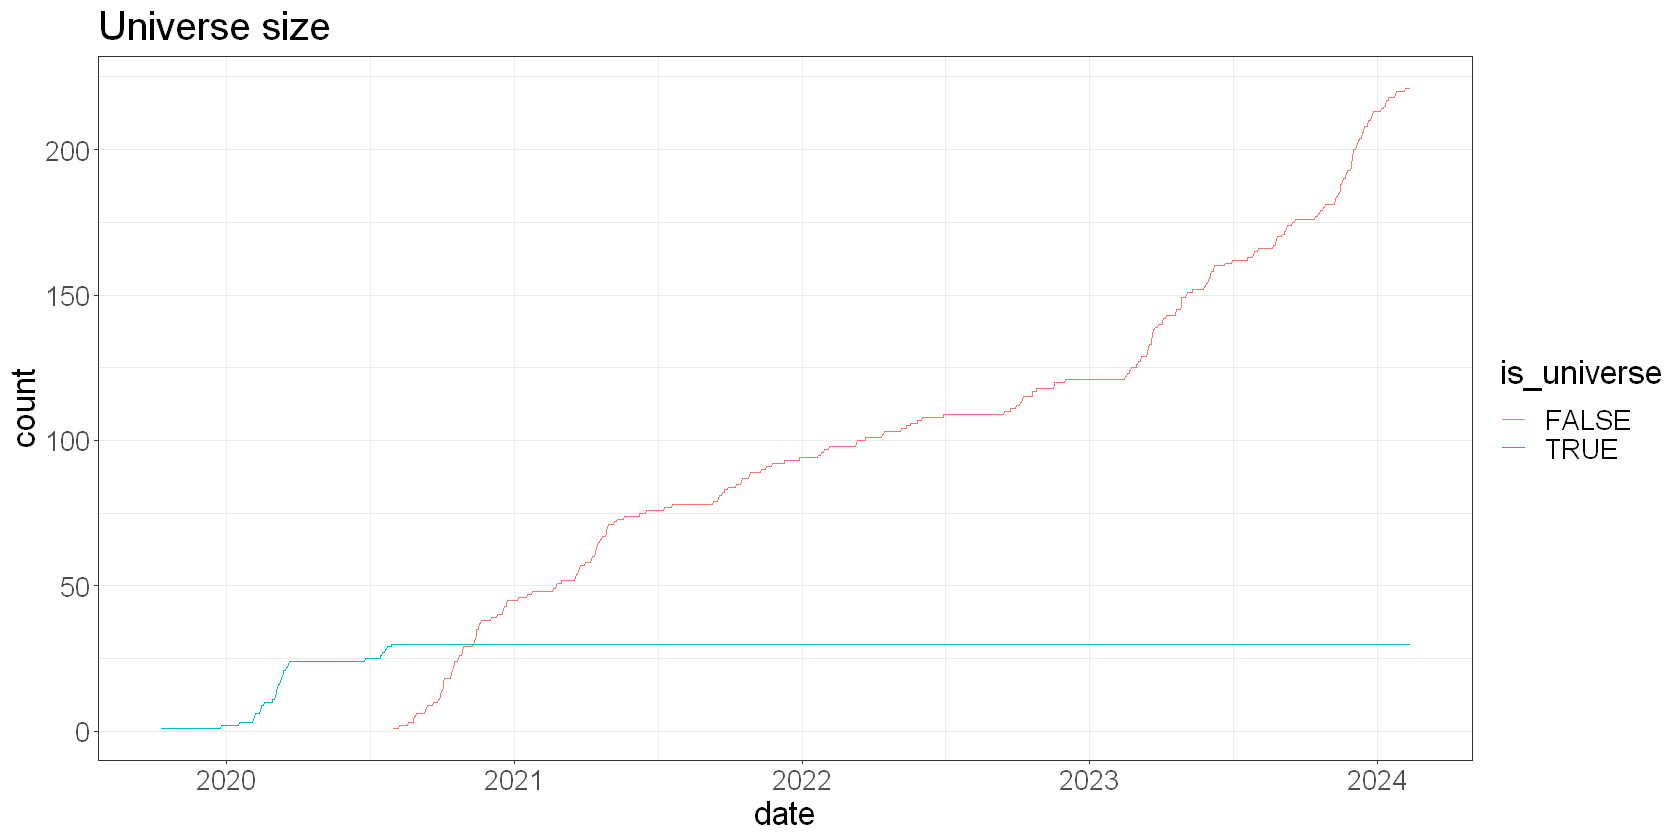

In [3]:
# get the top 30 by trailing 30-day volume
# exclude from universe until we have enough data to do a covariance estimate (see later)
trading_universe_size <- 30
ew_cov_init_wdw <- 30

universe <- perps %>%
  group_by(ticker) %>% 
  # also calculate returns for later
  mutate(
    total_return_simple = funding_rate + (close - lag(close, 1))/lag(close, 1),
    total_return_log = log(1 + total_return_simple),
    total_fwd_return_simple = dplyr::lead(funding_rate, 1) + (dplyr::lead(close, 1) - close)/close,
    total_fwd_return_log = log(1 + total_fwd_return_simple),
    trail_volume = roll_mean(dollar_volume, 30)
  ) %>% 
  mutate(days_since_listing = row_number()) %>%   # the number of days we have data for each ticker
  na.omit() %>%
  ungroup() %>% 
  # exclude from volume ranking - won't matter if we use a rolling volume calculated with more than the covariance initialisation window as will drop these rows using na.omit
  mutate(to_exclude = days_since_listing < ew_cov_init_wdw) %>%   
  group_by(date) %>%
  mutate(
    volume_rank = if_else(to_exclude, NA_integer_, row_number(-trail_volume)),
    is_universe = volume_rank <= trading_universe_size,
  ) 

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) + 
  geom_line() + 
  labs(
    title = 'Universe size'
)

## Calculate features

Next, calculate our features as before. We have:  
- Short-term (10-day) cross-sectional momentum (bucketed into deciles by date)
- Short-term (1-day) cross-sectional carry (also bucketed into deciles by date)
- A breakout feature defined as the number of days since the 20-day high which we use as a time-series return predictor. 

In [4]:
# calculate features as before
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = 9.5 - rolling_days_since_high_20(close),  # puts this feature on a scale -9.5 to +9.5
    momo = close - lag(close, 10)/close,
    carry = funding_rate
  ) %>%
  ungroup() %>% 
  na.omit()

# create a model df on our universe with momo and carry features scaled into deciles
model_df <- features %>%
  filter(is_universe) %>% 
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    momo_decile = ntile(momo, 10),
    # also calculate demeaned return for everything in our universe each day for later
    demeaned_return = total_return_simple - mean(total_return_simple, na.rm = TRUE),
    demeaned_fwd_return = total_fwd_return_simple - mean(total_fwd_return_simple, na.rm = TRUE)
  ) %>% 
  ungroup()

  # start simulation from date we first have n tickers in the universe
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(date)

## Model expected returns

We'll model our features as expected returns. See [here]((https://robotwealth.com/how-to-model-features-as-expected-returns/)) for a detailed exploration of this topic. 

In [5]:
# use a 90-day window and refit every 10 days
is_days <- 90
step_size <- trading_universe_size*10  

# rolling model for cross-sectional features
roll_xs_coeffs_df <- model_df %>% 
  filter(date >= start_date) %>% 
  regress(
    demeaned_fwd_return ~ carry_decile + momo_decile,
    m("lm", vcov. = "HAC"),  
    .cv = "sliding_index", 
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),  
    .force_cv = TRUE, 
    .return_slices = TRUE
  )

# rolling model for time series features 
breakout_cutoff <- 5.5  # below this level, we set our expected return to zero
roll_ts_coeffs_df <- model_df %>% 
  filter(date >= start_date) %>% 
  # setting regression weights to zero when breakout < breakout_cutoff will give these data points zero weight in estimating coefficients
  mutate(regression_weights = case_when(breakout < breakout_cutoff ~ 0, TRUE ~ 1)) %>% 
  regress(
    total_fwd_return_simple ~ breakout,
    m("lm", vcov. = "HAC"), 
    .weights = "regression_weights", 
    .cv = "sliding_index", 
    .cv_args = list(lookback = days(is_days), step = step_size, index = "date"),  
    .force_cv = TRUE, 
    .return_slices = TRUE
  )

This results in a nested dataframe that contains the model objects and various metadata:

In [6]:
roll_xs_coeffs_df %>% head
roll_ts_coeffs_df %>% select(-settings) %>% head

model,estimator_fct,size (MB),grid_id,model_object,settings,slice_id
<chr>,<chr>,<dbl>,<chr>,<list>,<list>,<chr>
lm,stats::lm,1.360960,#0010000,<environment: 0x000002c9993fbe90>,HAC,2021-02-11
lm,stats::lm,1.367016,#0010000,<environment: 0x000002c9994915b8>,HAC,2021-02-21
lm,stats::lm,1.380032,#0010000,<environment: 0x000002c9997f4918>,HAC,2021-03-03
lm,stats::lm,1.384864,#0010000,<environment: 0x000002c999c1dc98>,HAC,2021-03-13
lm,stats::lm,1.384808,#0010000,<environment: 0x000002c999f2ada0>,HAC,2021-03-23
lm,stats::lm,1.384944,#0010000,<environment: 0x000002c98f421ae8>,HAC,2021-04-02


model,estimator_fct,size (MB),grid_id,model_object,slice_id
<chr>,<chr>,<dbl>,<chr>,<list>,<chr>
lm,stats::lm,1.245552,#0010000,<environment: 0x000002c99633fe90>,2021-02-11
lm,stats::lm,1.257864,#0010000,<environment: 0x000002c995893588>,2021-02-21
lm,stats::lm,1.254896,#0010000,<environment: 0x000002c989f4bd30>,2021-03-03
lm,stats::lm,1.255688,#0010000,<environment: 0x000002c9891edc98>,2021-03-13
lm,stats::lm,1.260624,#0010000,<environment: 0x000002c988f475b8>,2021-03-23
lm,stats::lm,1.257784,#0010000,<environment: 0x000002c987e70f28>,2021-04-02


`slice_id` is the date the model goes out of sample - so we'll need to make sure that we align our model coefficients to avoid using them on the data they were fitted on. 

This requires a little data wrangling:

In [7]:
# for this to work, need to install.packages("sandwich", "lmtest")
xs_coefs <- roll_xs_coeffs_df %>% 
  coef()

xs_coefs_df <- xs_coefs %>% 
  ungroup() %>% 
  select(term, estimate, slice_id) %>% 
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>% 
  mutate(slice_id = as_date(slice_id)) %>% 
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>% 
  rename("xs_intercept" = `(Intercept)`)

ts_coefs <- roll_ts_coeffs_df %>% 
  coef()

ts_coefs_df <- ts_coefs %>% 
  ungroup() %>% 
  select(term, estimate, slice_id) %>% 
  pivot_wider(id_cols = slice_id, names_from = term, values_from = estimate) %>% 
  mutate(slice_id = as_date(slice_id)) %>% 
  # need to lag slice id to make it oos
  # slice_id_oos is the date we start using the parameters
  mutate(slice_id_oos = lead(slice_id)) %>% 
  rename("ts_intercept" = `(Intercept)`)

xs_coefs_df %>% head
# ts_coefs_df %>% head

slice_id,xs_intercept,carry_decile,momo_decile,slice_id_oos
<date>,<dbl>,<dbl>,<dbl>,<date>
2021-02-11,-0.004872208,0.001732322,-0.0008239738,2021-02-21
2021-02-21,-0.006129608,0.001902553,-0.0007640190,2021-03-03
2021-03-03,-0.009538180,0.002148154,-0.0003897220,2021-03-13
2021-03-13,-0.008374302,0.001953655,-0.0004141515,2021-03-23
2021-03-23,-0.008275046,0.002211137,-0.0006898811,2021-04-02
2021-04-02,-0.008613423,0.002413307,-0.0008298451,2021-04-12


Here's a plot of our cross-sectional features' regression coefficients through time:

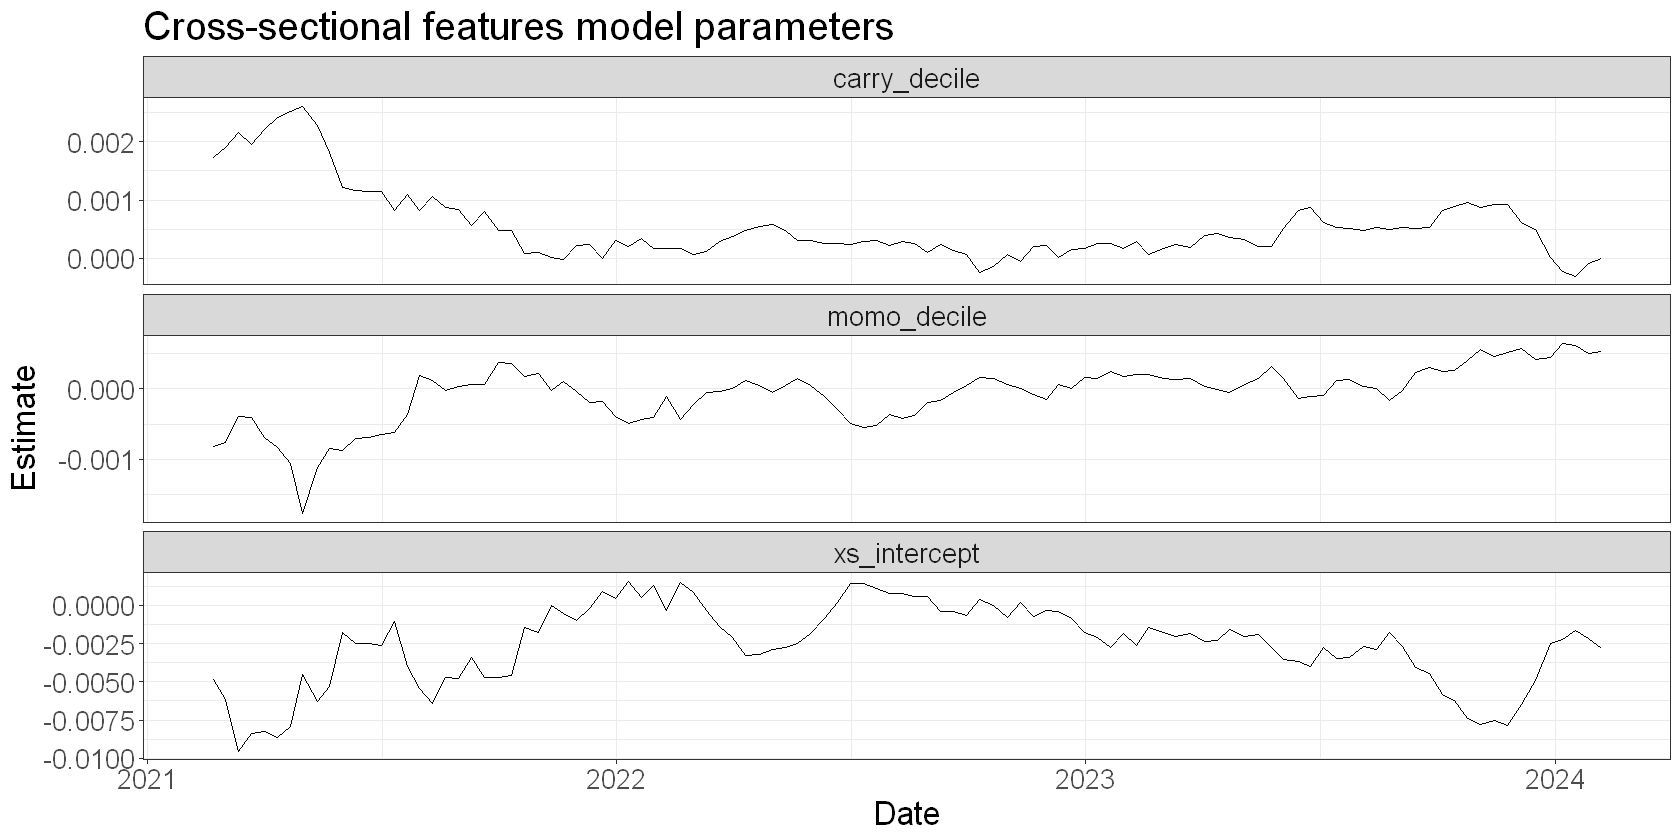

In [8]:
# plot cross-sectional estimates
xs_coefs_df %>% 
  select(-slice_id) %>% 
  pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>% 
  ggplot(aes(x = slice_id_oos, y = estimate)) +
  geom_line() +
  facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
  labs(
    title = "Cross-sectional features model parameters",
    x = "Date",
    y = "Estimate"
  )

# plot time-series estimates
# ts_coefs_df %>% 
#   select(-slice_id) %>% 
#   pivot_longer(cols = -slice_id_oos, names_to = "coefficient", values_to = "estimate") %>% 
#   ggplot(aes(x = slice_id_oos, y = estimate)) +
#   geom_line() +
#   facet_wrap(~coefficient, ncol = 1, scales = "free_y") +
#   labs(
#     title = "Time-series features model parameters",
#     x = "Date",
#     y = "Estimate"
#   )

The estimates for the coefficients for our carry and momentum features change over time to reflect the changing relationship with forward returns.  

In particular, notice how the momentum coefficient flipped sign a few times, but especially from mid-2022, which is in line with our understanding of how the feature evolved. 

## Plot frictionless returns to our features

Now we can plot a time series of returns to a frictionless trading strategy based on these expected return estimates. This isn't a backtest - it makes no attempt to address real-world issues such as costs and turnover. It simply plots the returns to our predictions of expected returns over time.

I won't actually use the linear model of the breakout feature - instead I'll just set its expected return to 0.002 when it's greater than 5 and 0 otherwise. 

I'll calculate target positions proportional to their cross-sectional return estimates. I'll then let the breakout feature tilt the portfolio net long, but I'll constrain the maximum delta that this feature can add to a position.

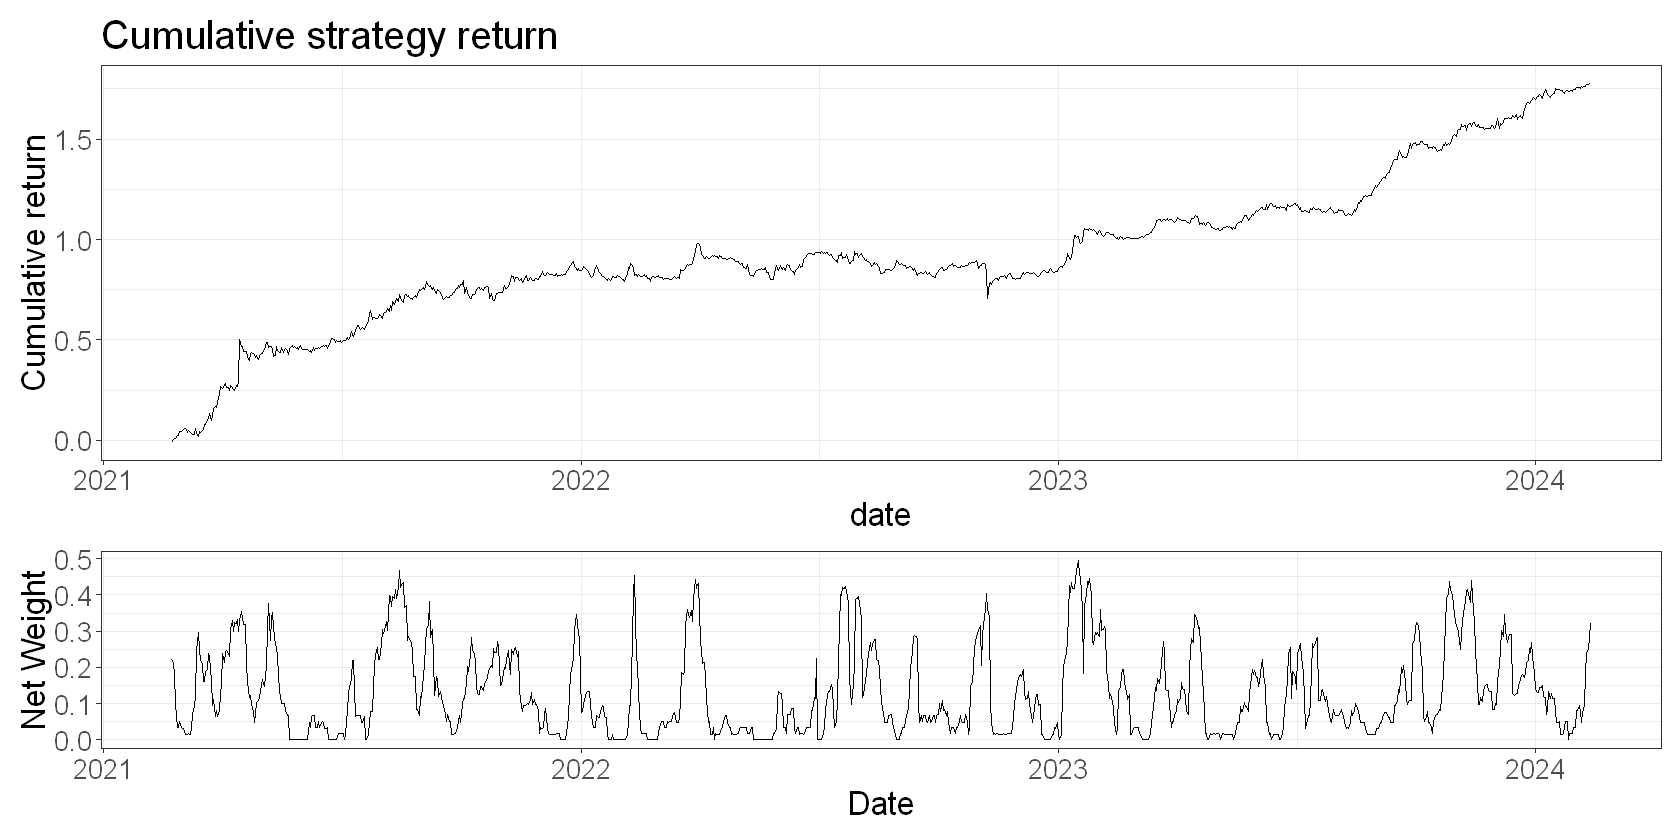

In [9]:
# join and fill using slice_id to designate when the model goes oos
exp_return_df <- model_df %>% 
  left_join(
    xs_coefs_df %>% left_join(ts_coefs_df, by = c("slice_id", "slice_id_oos")), 
    by = join_by(closest(date > slice_id_oos)), suffix = c("_factor", "_coef")
  ) %>% 
  na.omit() %>% 
  # forecast cross-sectional expected return as
  mutate(expected_xs_return = carry_decile_factor*carry_decile_coef + momo_decile_factor*momo_decile_coef + xs_intercept ) %>% 
  # mean expected xs return each day is zero
  # let total expected return be xs return + ts return - allows time series expected return to tilt weights
  mutate(expected_ts_return = case_when(breakout_factor >= 5.5 ~ 0.002, TRUE ~ 0)) %>% 
  ungroup() 

# long-short the xs expected return
# layer ts expected return on top
# position by expected return

# 1 in the numerator lets it get max 100% long due to breakout
max_ts_pos <- 0.5/trading_universe_size

strategy_df <- exp_return_df %>% 
  filter(date >= start_date) %>% 
  group_by(date) %>% 
  mutate(xs_position = expected_xs_return - mean(expected_xs_return, na.rm = TRUE)) %>% 
  # scale positions so that leverage is 1
  group_by(date) %>% 
  mutate(xs_position = if_else(xs_position == 0, 0, xs_position/sum(abs(xs_position)))) %>%
  # layer ts expected return prediction
  ungroup() %>% 
  mutate(ts_position = sign(expected_ts_return)) %>% 
  # constrain maximum delta added by time series prediction
  mutate(ts_position = if_else(ts_position >= 0, pmin(ts_position, max_ts_pos), pmax(ts_position, -max_ts_pos))) %>% 
  mutate(position = xs_position + ts_position) %>% 
  # strategy return
  mutate(strat_return = position*total_fwd_return_simple) %>% 
  # scale back to leverage 1
  group_by(date) %>% 
  mutate(position = if_else(position == 0, 0, position/sum(abs(position)))) 
  
returns_plot <- strategy_df %>%
  group_by(date) %>% 
  summarise(total_ret = sum(strat_return)) %>% 
  ggplot(aes(x = date, y = cumsum(log(1+total_ret)))) +
  geom_line() +
  labs(
    title = "Cumulative strategy return",
    y = "Cumulative return"
  )

weights_plot <- strategy_df %>%
  summarise(net_pos = sum(position)) %>% 
  ggplot(aes(x = date, y = net_pos)) +
  geom_line() +
  labs(
    x = "Date",
    y = "Net Weight"
  )

returns_plot / weights_plot + plot_layout(heights = c(2,1))

## Setting up the optimisation framework

There are a few things we need for our optimisation framework:  
- A dataframe of prices and expected returns for all the tickers that were ever in the universe
- A risk model - we'll use a shrunk exponentially weighted covariance matrix
- We'll need a covariance matrix for each day of our simulation, so we'll compute these prior to running the simulation and store them in a list
- We'll also need a function for doing the optimisation at each time step and returning the weights for the next period
- Finally, we'll need to figure out appropriate values for lambda and tau (the parameters that control our risk and propensity to trade). We'll do this by testing out a few values on a sample of our data. We'll do this using parallel processing to speed things up a bit. 

Then, we can do our actual simulation. 

### Prices and expected returns dataframes

First, we make a dataframe of prices and expected returns for all the tickers that were ever in the tradeable universe:

In [71]:
# tickers that were ever in the universe
universe_tickers <- features %>%
  filter(is_universe) %>%
  pull(ticker) %>%
  unique()

# universe_tickers

In [11]:
strategy_df <- exp_return_df %>% 
  filter(date >= start_date) %>% 
  group_by(date) %>% 
  mutate(expected_xs_return = expected_xs_return - mean(expected_xs_return, na.rm = TRUE)) %>% 
  ungroup() %>% 
  mutate(expected_return = expected_xs_return + expected_ts_return) %>% 
  select(date, ticker, expected_return) %>% 
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    features %>% 
      filter(ticker %in% universe_tickers) %>% 
      select(date, ticker, close, total_fwd_return_simple, funding_rate), 
    by = c("date", "ticker")
  ) %>% 
  arrange(date, ticker) %>%
  filter(date >= start_date)

In [12]:
# get same length exp returns vector for each date
exp_returns_wide <- strategy_df %>% 
  select(ticker, date, expected_return) %>% 
  # will give NA where a ticker didn't exist
  pivot_wider(id_cols = date, names_from = ticker, values_from = expected_return)

### Risk model 

Next, we need a risk model for each day in our simulation. 

We'll use an exponentially weighted covariance estimate - this puts more weight on recent data and less on the past and tends to remove the big jumps you get using a fixed window approach. See [here](https://robotwealth.com/an-expenonetially-weighted-covariance-matrix-in-r/) for more details on this approach. 

We'll also shrink our covariance matrix:
- Off-diagonal elements (covariances) will be shrunk towards zero to reflect our uncertainty.
- On-diagonal elements (variances) will be shrunk towards the average variance.

First, make our exponentially weighted covariance estimates:

In [13]:
# EWMA covariance estimate
# note definition of lambda in line with Risk Metrics
# ie higher values of lambda put less weight on the most recent returns and more weight on historical returns.
ewma_cov <- function(x, y, lambda, initialisation_wdw = 100) {
  # check that x and y are the same length and greater than initialisation_wdw
  stopifnot("x and y must be of equal length" = length(x) == length(y))
  if(length(x) <= initialisation_wdw) {
    ewma_cov <- rep(NA, length(x))
    return(ewma_cov)
  }

  # create initialisation window and estimation window
  init_x = x[1:initialisation_wdw]
  init_y = y[1:initialisation_wdw]

  num_obs <- length(x)

  # initial covariance and mean return estimates
  old_cov <- cov(init_x, init_y)
  old_x <- mean(init_x)
  old_y <- mean(init_y)

  # preallocate output vector
  ewma_cov <- vector(mode = "numeric", length = num_obs)

  # pad with NA for initialisation window
  ewma_cov[1:initialisation_wdw] <- NA

  # covariance estimate
  for(i in c((initialisation_wdw+1):num_obs)) {
    ewma_cov[i] <- lambda*old_cov + (1 - lambda)*(old_x * old_y)
    old_cov <- ewma_cov[i]
    old_x <- x[i]
    old_y <- y[i]
  }
  ewma_cov
}

In [14]:
cov_lambda <- 0.995
wdw <- ew_cov_init_wdw

returns <- features %>% 
  filter(ticker %in% universe_tickers) %>% 
  select(ticker, date, total_return_simple)

# long dataframe of pairwise EW covariances
ewma_covs <- returns %>%
  full_join(returns, by = "date") %>%
  na.omit() %>%
  ungroup() %>%
  # get all combinations (tickers) and remove duplicate combos (eg BTC-ETH, ETH-BTC)
  mutate(tickers = ifelse(ticker.x < ticker.y, glue("{ticker.x}, {ticker.y}"), glue("{ticker.y}, {ticker.x}"))) %>%
  distinct(date, tickers, .keep_all = TRUE) %>%
  # calculate rolling pairwise ewma correlations
  group_by(tickers) %>%
  arrange(date, .by_group = TRUE) %>%
  mutate(ewma_cov = ewma_cov(total_return_simple.x, total_return_simple.y, lambda = cov_lambda, initialisation_wdw = ew_cov_init_wdw)) %>%
  select(date, tickers, ewma_cov, ticker.x, ticker.y) %>%
  na.omit() %>% 
  ungroup()

tail(ewma_covs)

date,tickers,ewma_cov,ticker.x,ticker.y
<date>,<chr>,<dbl>,<chr>,<chr>
2024-02-07,"ZRXUSDT, ZRXUSDT",0.003337849,ZRXUSDT,ZRXUSDT
2024-02-08,"ZRXUSDT, ZRXUSDT",0.003321164,ZRXUSDT,ZRXUSDT
2024-02-09,"ZRXUSDT, ZRXUSDT",0.003306101,ZRXUSDT,ZRXUSDT
2024-02-10,"ZRXUSDT, ZRXUSDT",0.003290074,ZRXUSDT,ZRXUSDT
2024-02-11,"ZRXUSDT, ZRXUSDT",0.003274115,ZRXUSDT,ZRXUSDT
2024-02-12,"ZRXUSDT, ZRXUSDT",0.003259633,ZRXUSDT,ZRXUSDT


Here's a plot of some covariance estimates for BTC and various coins:

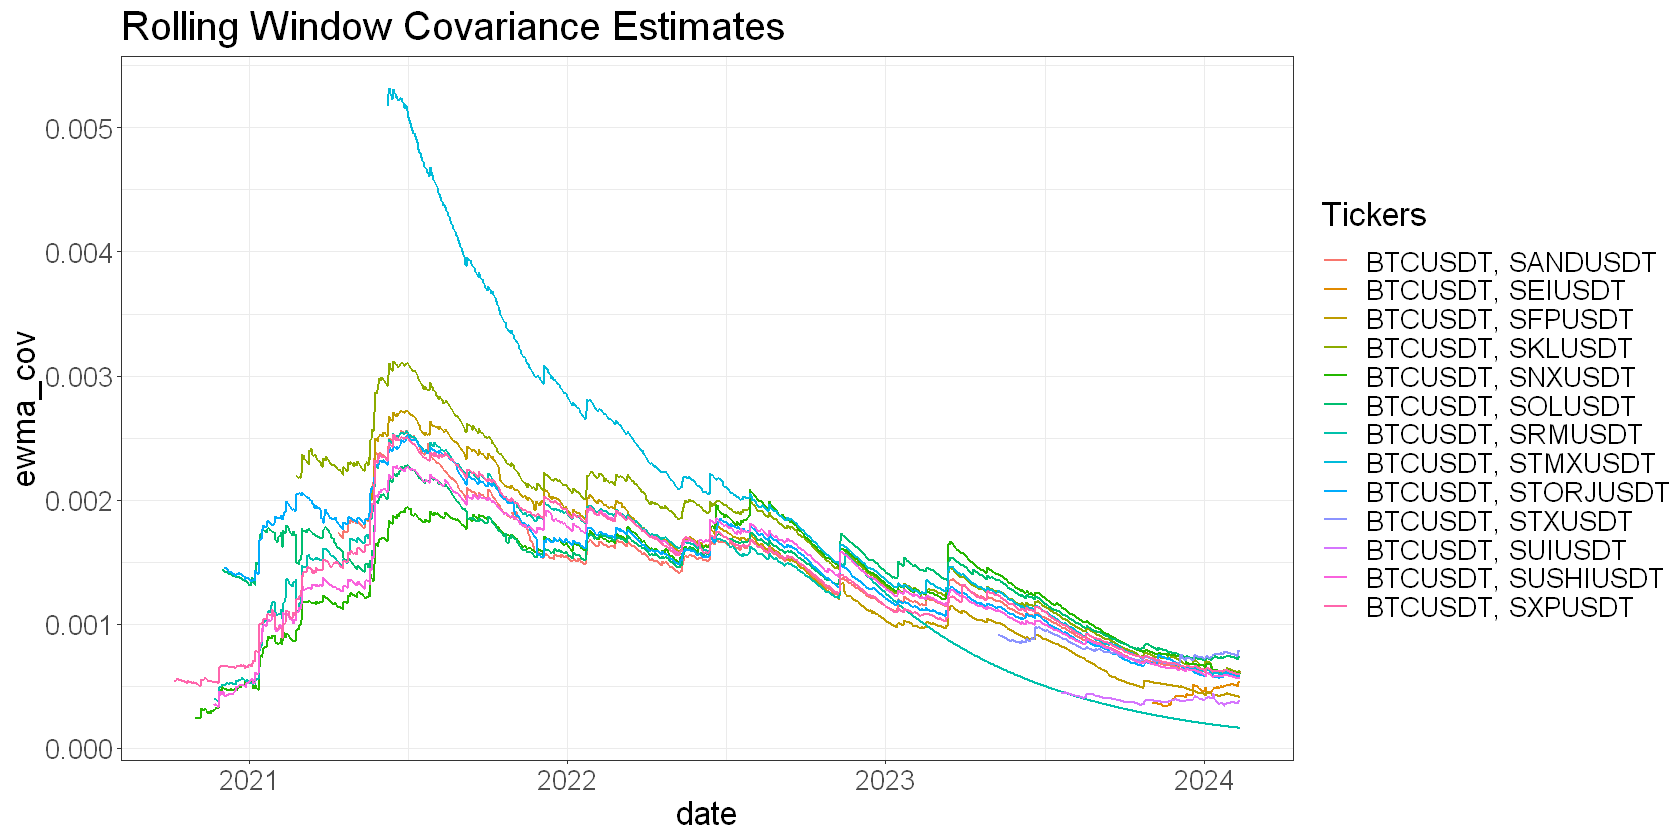

In [15]:
# plot pairwise rolling covariances
ewma_covs %>%
  filter(str_starts(tickers, "BTCUSDT, S")) %>%
  ggplot(aes(x = date, y = ewma_cov, colour = tickers)) +
    geom_line(size=0.8) +
    labs(
      title = "Rolling Window Covariance Estimates",
      colour = "Tickers"
    )

We'll also need some functions for extracting today's covariance matrix from our long dataframe of pairwise covariances, making sure it's symmetrical and positive semi definite, and shrinking its values.  

I've also included a function `extend_covmat` that extends today's covariance matrix to include all the tickers that were ever in the universe. That's just to make the optimisation loop a little simpler - we can use consistent expected returns vectors and covariance matrixes at each iteration. For tickers not in the tradeable universe on a particular day, we set their:
- expected return to NA
- pairwise covariances to zero
- variances to the average variance of tradeable assets

We also explicitly constrain their weights to be zero in the optimisation. 

In [16]:
# functions for wrangling covariance matrix
library(Matrix) 
library(matrixcalc)

get_today_covmat <- function(ewma_covs_long, today_date) {
    today_cov_df <- ewma_covs_long %>%
        ungroup() %>% 
        filter(date == today_date) %>% 
        select(ticker.x, ticker.y, ewma_cov) %>%
        pivot_wider(names_from = ticker.y, values_from = ewma_cov) %>%  # , names_prefix = "cov_"
        column_to_rownames(var = "ticker.x")
    
    # check rownames and colnames match
    stopifnot("error making today's cov matrix" = all.equal(rownames(today_cov_df), colnames(today_cov_df)))
    today_covmat <- as.matrix(today_cov_df)
    today_covmat[lower.tri(today_covmat)] <- t(today_covmat)[lower.tri(today_covmat)]
    
    # return nearest positive semi-definite matrix
    today_covmat <- nearPD(today_covmat)
    return(today_covmat$mat)
}

#' shrinks covs towards zero, reflecting uncertainty in cov estimates. may increases variances.
#' @param shrinkage_intensity: a value between 0 and 1. 0 means no shrinkage (use the original covmat), 1 means full shrinkage (use only the target_matrix)
shrink_covmat <- function(covmat, shrinkage_intensity = 0.9) {
    # average variance from the diagonal 
    average_variance <- mean(diag(covmat))
    # shrinkage target matrix (identity matrix scaled by average variance)
    target_matrix <- diag(average_variance, nrow = ncol(covmat))
    # shrunk covariance matrix
    covmat_shrunk <- (1 - shrinkage_intensity) * covmat + shrinkage_intensity * target_matrix

    return(covmat_shrunk)
}

#' extend covmat to cover all tickers in the tradeable universe
#' put average variance on the diagonal, zeroes elsewhere
#' intent is that optimisation will explicitly constrain weights for assets not yet in the universe to 0
extend_covmat <- function(covmat, all_tickers) {
    current_tickers <- colnames(covmat) 
    
    full_covmat <- matrix(0, nrow = length(all_tickers), ncol = length(all_tickers),
         dimnames = list(all_tickers, all_tickers))
    
    current_tickers_ordered <- intersect(all_tickers, rownames(covmat))

    # ensure covmats are ordered correctly
    covmat_reordered <- covmat[current_tickers_ordered, current_tickers_ordered] %>% 
      # ensure is Matrix type for compatibility
      as.matrix()
    full_covmat <- full_covmat[all_tickers, all_tickers]

    # replace in full_covmat
    full_covmat[current_tickers_ordered, current_tickers_ordered] <- covmat_reordered

    # replace zeros on diagonal with average variance
    zero_diag_indices <- which(diag(full_covmat) == 0)
    average_variance <- mean(diag(covmat))
    diag(full_covmat)[zero_diag_indices] <- average_variance
    
    return(full_covmat)
}

wrangle_covmat <- function(ewma_covs_long, date, tickers, shrinkage_intensity = 0.9) {
    today_covmat <- get_today_covmat(ewma_covs_long, date) %>% 
      shrink_covmat(shrinkage_intensity = shrinkage_intensity) %>% 
      extend_covmat(all_tickers = tickers)

    # check
    if(is.positive.semi.definite(today_covmat, tol=1e-8)){
        if(isSymmetric(today_covmat)) {
            glue("covmat crated for {date} not symmetric")
        }
    } else {
        glue("covmat crated for {date} not PSD")
    }    
    
    return(today_covmat)
}


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'matrixcalc'


The following object is masked from 'package:CVXR':

    vec




Next we precompute our covariance estimates for each day in our simulation and store them in a list. This just saves a bit of time in the optimisation loop. 

In [17]:
# precompute covariances matrixes 
simulation_start_date <- start_date + days(100)  # allow for first in-sample period - otherwise we run lots of simulation loops for zero weights
exp_returns_sim_df <- exp_returns_wide %>% filter(date >= simulation_start_date)

dates <- exp_returns_sim_df$date
covmat_list <- map(dates, ~wrangle_covmat(ewma_covs, .x, tickers = universe_tickers, shrinkage_intensity = 0.9))

### Define optimisation function

Next we define a function for finding our optimal weights at each time step. I'll use the mean-variance optimisation with costs. We explore this in more detail in [this article](https://robotwealth.com/building-intuition-for-trading-with-convex-optimisation-with-cvxr/).

Notice that we constrain the portfolio to be unleveraged (max total weight less than or equal to 1), but we don't put a constraint on how *net* long or short the portfolio can be. That means that in the extreme, we could end up being fully long or fully short. Below, I'll show you an example of constraining the net position as well. 

We also pass `na_idxs` to tell the optimiser which assets in our expected returns vector are not in the tradeable universe and should therefore get a weight of zero. 

In [18]:
# define our mvo function
mvo_with_costs <- function(expected_returns, current_weights, na_idxs = c(), costs, covmat, lambda = 1, tau=1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # define a risk term as w*Sigma*w
    # quad_form is a CVXR function for doing w*Sigma*w
  risk_term <- quad_form(weights, covmat)
  # define our objective
    # maximise our alpha less our risk term multiplied by some factor, lambda, less our costs term multiplied by tau
  objective <- Maximize(alpha_term - lambda*risk_term - tau*costs_term)
  # apply our no leverage constraint
  constraints <- list(cvxr_norm(weights, 1) <= 1, weights[na_idxs] == 0)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the values of the variable we solved for
  result$getValue(weights)
}

### Explore lambda-tau parameter space

Next we need to figure out some reasonable values for lambda (our risk aversion) and tau (our propensity to trade).  

If you need a refresher on lambda and tau, see the previous article on [building intuition for optimisation](https://robotwealth.com/building-intuition-for-trading-with-convex-optimisation-with-cvxr/). The TLDR is:

- Higher values of lambda will put more weight on the risk term and lead to higher diversification and eventually to reduced position sizes. 
- Higher values of tau will reduce our trading by requiring a greater expected return hurdle. 

We probably don't need to run the simulation over our entire history in order to find reasonable values of lambda and tau. So we'll just use 500 days to figure out our parameter values, then do a full simulation on that single parameter set. 

We'll loop over four values of lambda and five values of tau, for a total of 20 simulations over 500 days each. And we'll do these in parallel to speed things up.

Here's how to set up a parallel backend and prepare each worker environment:

In [68]:
library(doParallel)
library(foreach)

# register parallel backend
num_cores <- detectCores() - 1  # leave one core free
cl <- makeCluster(num_cores)
registerDoParallel(cl)

# use clusterEvalQ to define functions and objects available to each worker
clusterExport(
  cl, 
  varlist = c("get_today_covmat", "shrink_covmat", "extend_covmat", "wrangle_covmat", "mvo_with_costs", "universe_tickers", "exp_returns_sim_df", "covmat_list")
)

# load libraries in each worker
clusterEvalQ(cl, {
  library(CVXR); library(Matrix); library(matrixcalc); library(dplyr); library(tidyr); library(glue)
})

Loading required package: foreach


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package: iterators

Loading required package: parallel



[[1]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[2]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[3]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[4]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[5]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[6]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"      

[[7]]
 [1] "glue"       "tidyr"      "dplyr"      "matrixcalc" "Matrix"    
 [6] "CVXR"       "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"

Next, define our parameters for the simulations:

In [19]:
num_days <- nrow(exp_returns_wide)
lambdas <- c(0.1, 0.3, 1, 3)
taus <- c(0.003, 0.1, 0.3, 1, 3)
date_idxs_to_do <- c(1:500)
costs <- 0.15/100

Finally, we can do our 500-day simulations for each combination of lambda and tau in parallel. This still takes a while to complete, so we'll save the results to disk:

In [70]:
# custom combine function for flattening results of foreach to one big list
# ensures that each result from the inner loop is appended to the main list, rather than nesting it further 
# results in a flat structure where each element is a list corresponding to an iteration over lambda and tau without deep nesting
# requres .init arg of foreach to be list() - initialises an empty list for storing the results
flatten_lists <- function(x, y) {
  c(x, y)
}

results <- foreach(lambda = lambdas, .combine = 'flatten_lists', .init = list()) %:%   # 
  foreach(tau = taus, .combine = 'flatten_lists', .init = list()) %dopar% {
   
   weights <- list()
   errors <- list()
   w0 <- rep(0, length(universe_tickers))
   for( i in date_idxs_to_do ) {
      # today's date
      d = exp_returns_sim_df$date[i]

      # cov estimate
      today_covmat <- covmat_list[[i]]

      # check cov matrix and exp returns vector are ticker-aligned
      # all.equal(exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(ticker), colnames(today_covmat))
      
      # get row of expected returns as a vector in the same order as the columns of the covariance matrix
      # contains NA at this point
      exp_rets <- exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(expected_return)
      
      # get na indexes
      # we'll explicitly constrain these to get zero weight
      na_idxs <- which(is.na(exp_rets))
      # convert NA to zero
      exp_rets[is.na(exp_rets)] <- 0
      
      # initialise w in case we get a solver error (can retain w0 in these cases)
      w <- w0
      
      # solve for next period's weights
      tryCatch({
         w <- mvo_with_costs(expected_returns = exp_rets, current_weights = w0, na_idxs = na_idxs, costs = costs, covmat = today_covmat, lambda = lambda, tau = tau)
      }, error = function(e) {
            # in case of solver error, log and retain existing weights
            errors[[i]] <- e
         }
      )
      
      # store weights
      # w is a one-column matrix
      weights[[i]] <- w
      w0 <- w 
    }
    # return a list with weights, parameters, and any errors
    list(list(weights = weights, lambda = lambda, tau = tau, errors = errors))
}
  
stopCluster(cl)

# save to disk
saveRDS(results, file = "lambda_tau_search_results_1_500.rds")

In [21]:
# read results from disk
# results <- readRDS("lambda_tau_search_results_1_500.rds")

### Wrangle simulation results

Our simulation results are a list of lists - one sublist for each lambda-tau combination. Each sublist contains 500 weights vectors (one for each day in the simulation), the values of lambda and tau, and a list of solver errors, if any occurred. 

We can make one big dataframe of weights for each lambda-tau combination using the awesome `purrr` tools:

In [22]:
# function for converting a day's weights vector to a dataframe
weights_mat_to_df <- function(x, d, lambda, tau, tickers) {
  x %>% 
    as_tibble(.name_repair = ~paste0("lambda_",lambda,"_tau_",tau)) %>% 
    mutate(date = d) %>%
    mutate(ticker = tickers)
}

# make one dataframe of weights for each lambda-tau combination
weights_dfs <- list()
for(i in seq_along(results)) {
  this_entry <- results[[i]]
  these_weights <- this_entry$weights
  this_lambda <- this_entry$lambda
  this_tau <- this_entry$tau

  weights_df <- purrr::map2(
    these_weights, 
    exp_returns_wide$date[date_idxs_to_do], 
    ~weights_mat_to_df(.x, .y, lambda = this_lambda, tau = this_tau, tickers = universe_tickers)
  ) %>% 
    bind_rows()
  
  weights_dfs[[i]] <- weights_df
}

# combine dataframes for each lmbda-tau combination into one big dataframe
all_weights <- weights_dfs %>% purrr::reduce(left_join, by = c("date", "ticker")) %>% 
  relocate(c(date, ticker))

head(all_weights)

date,ticker,lambda_0.1_tau_0.003,lambda_0.1_tau_0.1,lambda_0.1_tau_0.3,lambda_0.1_tau_1,lambda_0.1_tau_3,lambda_0.3_tau_0.003,lambda_0.3_tau_0.1,lambda_0.3_tau_0.3,⋯,lambda_1_tau_0.003,lambda_1_tau_0.1,lambda_1_tau_0.3,lambda_1_tau_1,lambda_1_tau_3,lambda_3_tau_0.003,lambda_3_tau_0.1,lambda_3_tau_0.3,lambda_3_tau_1,lambda_3_tau_3
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-10,BTCUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-11-10,ETHUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-11-10,BCHUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-11-10,XRPUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-11-10,EOSUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2020-11-10,LTCUSDT,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Let's look at how our different parameterisations impact the weights for BTC:

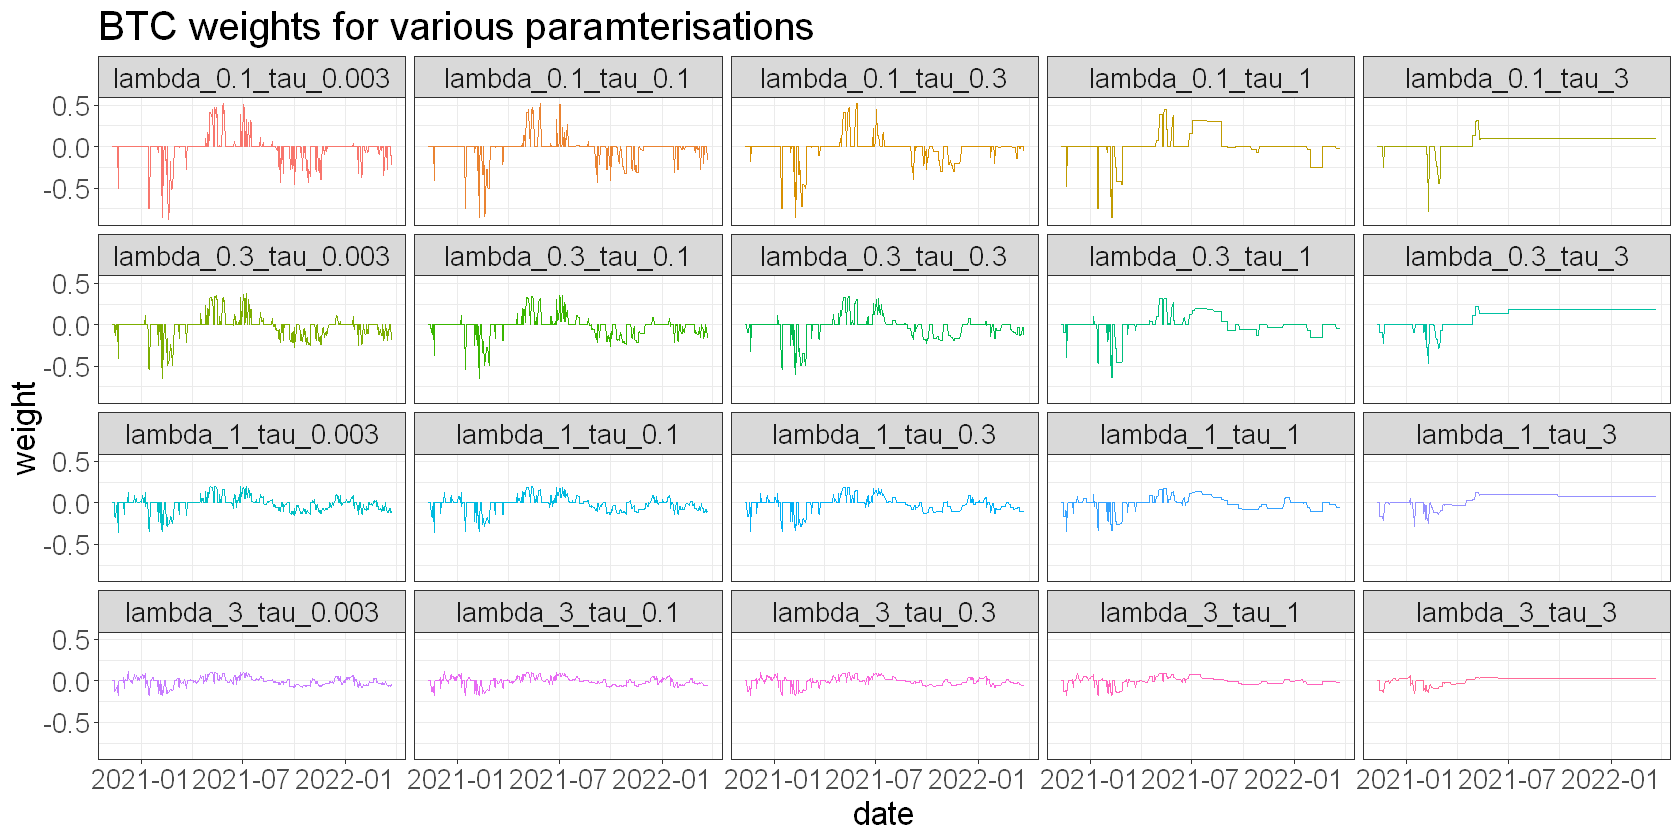

In [25]:
all_weights %>% 
  pivot_longer(cols = c(-date, -ticker), names_to = "parameterisation", values_to = "weight") %>% 
  filter(ticker == "BTCUSDT") %>% 
  ggplot(aes(x = date, y = weight, colour = parameterisation)) +
  geom_line() +
  facet_wrap(~parameterisation) +
  theme(legend.position = "none") +
  labs(
    title = "BTC weights for various paramterisations"
  )

You can see that as lambda increases, the weight we put on BTC decreases - as we increase lambda, the optimiser would start by assigning some of BTC's weight to other tickers in order to increase diversification, and as we increase lambda further, the total portfolio exposure would decrease, further reducing the weight on BTC.  

And you can see that as tau increases, there are fewer changes in those weights because we do less trading. In the extreme, we hold our existing position for far longer than we would like to. 

Let's look at how our total and net portfolio weight changes:

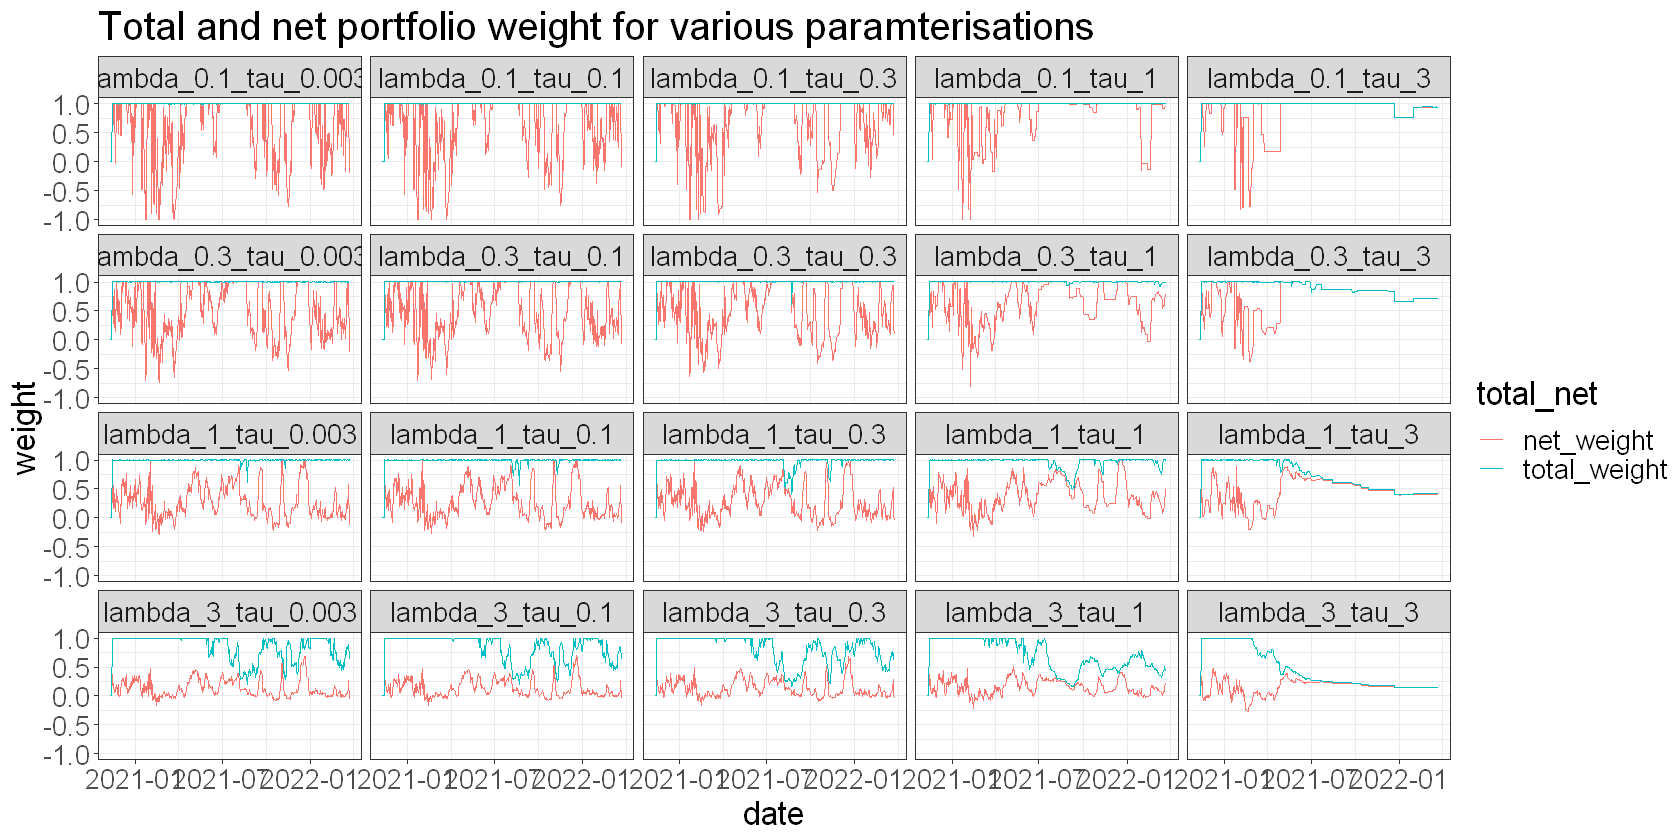

In [28]:
all_weights %>% 
  pivot_longer(cols = c(-date, -ticker), names_to = "parameterisation", values_to = "weight") %>% 
  group_by(parameterisation, date) %>% 
  summarise(total_weight = sum(abs(weight)), net_weight = (sum(weight)), .groups = "drop") %>%   
  pivot_longer(cols = c(total_weight, net_weight), names_to = "total_net", values_to = "weight")  %>% 
  ggplot(aes(x = date, y = weight, colour = total_net)) + 
  geom_line() + 
  facet_wrap(~parameterisation) +
  labs(
    title = "Total and net portfolio weight for various paramterisations"
  )

You can see that for lower values of lambda, the portfolio is mostly fully invested (blue lines). As we increase lambda, we have periods where we reduce our total portfolio exposure. This becomes more extreme as we increase lambda. 

Also notice that for lower values of lambda, we can have more extreme net long or short positions (red lines). As we increase lambda, our net position tends not to fluctuate as much. We also tend not be net short as often, reflecting the long-only nature of the breakout feature, and the fact that one or two large negative expected returns will have less impact as lambda increases. 

## Simulate our parameterisations

Next, we'll use `rsims` to run an accurate simulation for each of our parameterisations. See [this article](https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/) for more information and examples of using `rsims`. 

We'll assume costs of 0.15% of traded value. 

In [29]:
backtest_df <- all_weights %>% 
  pivot_longer(cols = c(-date, -ticker), names_to = "parameterisation", values_to = "weight") %>%  
  left_join(strategy_df, by = c("ticker", "date"))

head(backtest_df)

date,ticker,parameterisation,weight,expected_return,close,total_fwd_return_simple,funding_rate
<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-11-10,BTCUSDT,lambda_0.1_tau_0.003,0,NA,15167.88,0.03288394,-3e-04
2020-11-10,BTCUSDT,lambda_0.1_tau_0.1,0,NA,15167.88,0.03288394,-3e-04
2020-11-10,BTCUSDT,lambda_0.1_tau_0.3,0,NA,15167.88,0.03288394,-3e-04
2020-11-10,BTCUSDT,lambda_0.1_tau_1,0,NA,15167.88,0.03288394,-3e-04
2020-11-10,BTCUSDT,lambda_0.1_tau_3,0,NA,15167.88,0.03288394,-3e-04
2020-11-10,BTCUSDT,lambda_0.3_tau_0.003,0,NA,15167.88,0.03288394,-3e-04


In [30]:
params <- unique(backtest_df$parameterisation)
params

[1] "lambda_0.1_tau_0.003" "lambda_0.1_tau_0.1"   "lambda_0.1_tau_0.3"  
 [4] "lambda_0.1_tau_1"     "lambda_0.1_tau_3"     "lambda_0.3_tau_0.003"
 [7] "lambda_0.3_tau_0.1"   "lambda_0.3_tau_0.3"   "lambda_0.3_tau_1"    
[10] "lambda_0.3_tau_3"     "lambda_1_tau_0.003"   "lambda_1_tau_0.1"    
[13] "lambda_1_tau_0.3"     "lambda_1_tau_1"       "lambda_1_tau_3"      
[16] "lambda_3_tau_0.003"   "lambda_3_tau_0.1"     "lambda_3_tau_0.3"    
[19] "lambda_3_tau_1"       "lambda_3_tau_3"

In [31]:
# simulation for each parameterisation

# no trade buffer (trades controlled by tau parameter and are embedded in weights)
equity_curves <- vector("list", length = length(params))
results_dfs <- vector("list", length = length(params))
i <- 1
for( p in params ) {
    # get weights as a wide matrix 
    # note that date column will get converted to unix timestamp
    backtest_weights <- backtest_df %>%
        dplyr::filter(parameterisation == p) %>% 
        pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
        select(date, starts_with("weight")) %>%
        mutate(date = as.numeric(date)) %>% 
        data.matrix()

    # NA weights should be zero
    backtest_weights[is.na(backtest_weights)] <- 0

    # get prices as a wide matrix
    # note that date column will get converted to unix timestamp
    backtest_prices <- backtest_df %>% 
        dplyr::filter(parameterisation == p) %>% 
        pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
        select(date, starts_with("close_")) %>%
        mutate(date = as.numeric(date)) %>% 
        data.matrix()

    # get funding as a wide matrix
    # note that date column will get converted to unix timestamp
    backtest_funding <- backtest_df %>%
        dplyr::filter(parameterisation == p) %>% 
        pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
        select(date, starts_with("funding_rate_")) %>%
        mutate(date = as.numeric(date)) %>% 
        data.matrix()

    # simulation
    results_df <- fixed_commission_backtest_with_funding(
        prices = backtest_prices,
        target_weights = backtest_weights,
        funding_rates = backtest_funding,
        trade_buffer = 0.,
        initial_cash = 10000,
        margin = 0.05,
        commission_pct = 0.0015,
        capitalise_profits = FALSE
        ) %>%
        mutate(ticker = str_remove(ticker, "close_")) %>%
        # remove coins we don't trade from results
        drop_na(Value)

    margin <- results_df %>%
        group_by(Date) %>%
        summarise(Margin = sum(Margin, na.rm = TRUE))

    cash_balance <- results_df %>%
        filter(ticker == "Cash") %>%
        select(Date, Value) %>%
        rename("Cash" = Value)

    equity <- cash_balance %>%
        left_join(margin, by = "Date") %>% 
        mutate(Equity = Cash + Margin) %>% 
        select(Date, Equity) %>% 
        rename(!!p := Equity)
    
    equity_curves[[i]] <- equity
    results_dfs[[i]] <- results_df

    i <- i + 1
}

Plot equity curves for each 500-day simulation:

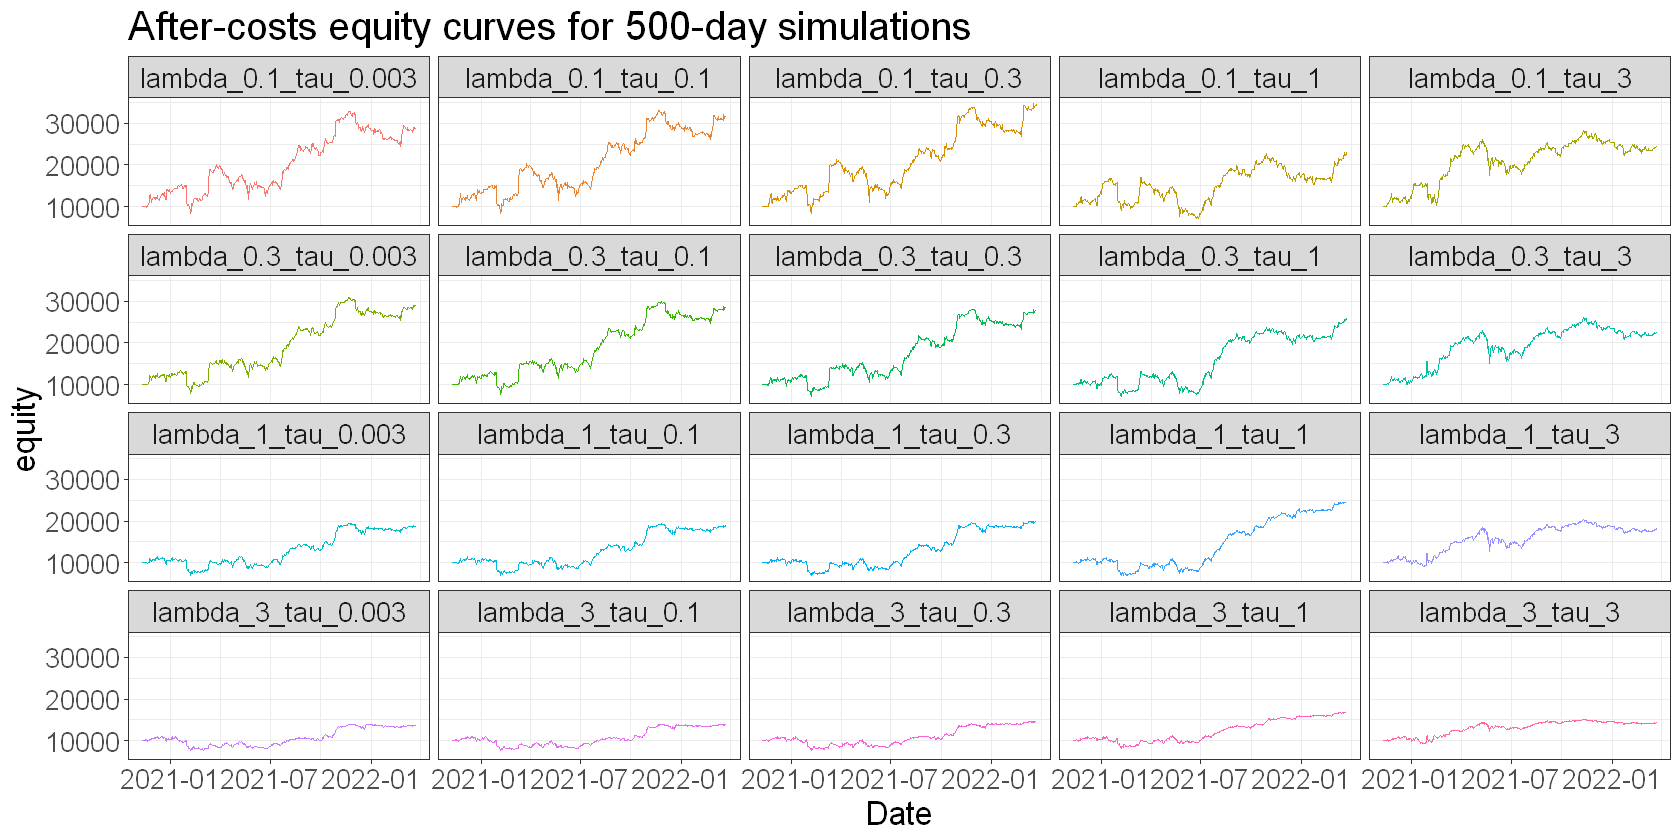

In [33]:
equity_curves %>% 
  purrr::discard(is.null) %>% 
  reduce(left_join, by = "Date") %>% 
  pivot_longer(-Date, names_to = "param", values_to = "equity") %>%
  ggplot(aes(x = Date, y = equity, colour = param)) +
  geom_line() +
  facet_wrap(~param) +
  theme(legend.position = "none") +
  labs(
    title = "After-costs equity curves for 500-day simulations"
  )

Eyeballing equity curves is illustrative, but let's also quantify these results. For each 500-day simulation, we'll calculate:
- Sharpe ratio
- Total return
- Average daily turnover (as percentage of allocated cash)

In [51]:
initial_cash <- 10000
i <- 1
dfs <- list()
for (r in results_dfs) {
  # get lambda and tau
  these_params <- str_extract_all(params[i],"[0-9]+\\.*[0-9]*", simplify = TRUE)
  this_lambda <- these_params[1, 1]
  this_tau <- these_params[1, 2]

  # average daily turnover
  average_turnover <- r %>%
    filter(ticker != "Cash") %>% 
    group_by(Date) %>% 
    summarise(turnover = 100*sum(abs(TradeValue))/initial_cash, .groups = "drop") %>% 
    summarise(ave_turnover = mean(turnover)) %>% 
    pull(ave_turnover)

  # total return
  equity <- equity_curves[[i]][, 2, drop = TRUE]

  fin_eq <- equity %>%
    tail(1) 

  init_eq <- equity%>%
    head(1) 

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- length(equity)
  ann_return <- total_return * 365/days
  
  # sharpe
  returns <- na.omit(equity/lag(equity) - 1)
  sharpe <- sqrt(365)*mean(returns)/sd(returns)

  # store results
  df <- data.frame(
    lambda = this_lambda,
    tau = this_tau,
    sharpe = sharpe,
    total_return = total_return,
    average_turnover = average_turnover
  )
  dfs[[i]] <- df

  i <- i + 1
}

metrics <- dfs %>% bind_rows()
metrics %>% arrange(desc(sharpe))

lambda,tau,sharpe,total_return,average_turnover
<chr>,<chr>,<dbl>,<dbl>,<dbl>
0.3,0.003,1.5979996,187.91581,86.563401
1,1,1.5843898,147.20999,26.719370
0.1,0.3,1.5632515,243.76855,62.853329
0.3,0.1,1.5582835,184.85528,74.244957
0.1,0.1,1.5049803,215.82454,82.633311
0.3,0.3,1.4733322,177.88543,57.872224
3,1,1.4360708,68.91465,23.088435
0.1,0.003,1.4106634,187.10321,98.365393
0.3,1,1.3676426,157.92362,28.740003


These metrics give you an idea of the tradeoffs:
- The parameters that resulted in our highest Sharpe turn over more than 85% of the portfolio daily. This would be hard to manage if you were trading by hand. 
- You could achieve a slightly lower Sharpe but turn over much less, for example with lambda = 1, tau = 1. This would be operationally simpler. 

Bear in mind though that these results only represent the first 500-days of the simulation, and there's no guarantee that they would be reflective of the results over the entire history. But they're a good starting point for thinking about the tradeoffs. 

For now, let's pick lambda = 1 and tau = 1 and simulate over the full sample:

In [52]:
lambda <- 1
tau <- 1
costs <- 0.15/100
   
weights <- list()
errors <- list()
w0 <- rep(0, length(universe_tickers))
for( i in c(1:length(exp_returns_sim_df$date)) ) {
    # today's date
    d = exp_returns_sim_df$date[i]

    # cov estimate
    today_covmat <- covmat_list[[i]]

    # check cov matrix and exp returns vector are ticker-aligned
    # all.equal(exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(ticker), colnames(today_covmat))
    
    # get row of expected returns as a vector in the same order as the columns of the covariance matrix
    # contains NA at this point
    exp_rets <- exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(expected_return)
    # get na indexes
    # we'll explicitly constrain these to get zero weight
    na_idxs <- which(is.na(exp_rets))
    # convert NA to zero
    exp_rets[is.na(exp_rets)] <- 0
    # initialise w in case we get a solver error (can retain w0 in these cases)
    w <- w0
    tryCatch({
        w <- mvo_with_costs(expected_returns = exp_rets, current_weights = w0, na_idxs = na_idxs, costs = costs, covmat = today_covmat, lambda = lambda, tau = tau)
    }, error = function(e) {
        # in case of solver error, log and retain existing weights
        errors[[i]] <- e
        }
    )
    
    # w is a one-column matrix
    weights[[i]] <- w
    w0 <- w 
}

results <- list(weights = weights, lambda = lambda, tau = tau, errors = errors)

saveRDS(results, file = "lambda_1_tau_1.rds")

In [55]:
# wrangle weights into a dataframe
weights_df <- purrr::map2(
  weights, 
  exp_returns_sim_df$date, 
  ~weights_mat_to_df(.x, .y, lambda = lambda, tau = tau, tickers = universe_tickers)
) %>% 
  bind_rows() %>% 
  rename("weight" = lambda_1_tau_1)

head(weights_df)

weight,date,ticker
<dbl>,<date>,<chr>
0,2021-02-18,BTCUSDT
0,2021-02-18,ETHUSDT
0,2021-02-18,BCHUSDT
0,2021-02-18,XRPUSDT
0,2021-02-18,EOSUSDT
0,2021-02-18,LTCUSDT


In [56]:
# join weights onto prices
backtest_df <- weights_df %>% 
  left_join(strategy_df, by = c("ticker", "date"))

head(backtest_df)

weight,date,ticker,expected_return,close,total_fwd_return_simple,funding_rate
<dbl>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,2021-02-18,BTCUSDT,NA,51663.6400,0.041106415,-0.00412394
0,2021-02-18,ETHUSDT,NA,1910.9900,0.007813203,-0.00516012
0,2021-02-18,BCHUSDT,NA,702.5500,0.015704896,-0.00711178
0,2021-02-18,XRPUSDT,NA,0.5302,0.030592698,-0.00688510
0,2021-02-18,EOSUSDT,NA,4.8000,0.077784750,-0.00550166
0,2021-02-18,LTCUSDT,NA,225.8000,0.020896880,-0.00616800


In [57]:
# simulate

# get weights as a wide matrix 
backtest_weights <- backtest_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("weight")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

# get prices as a wide matrix
backtest_prices <- backtest_df %>% 
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("close_")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# get funding as a wide matrix
backtest_funding <- backtest_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(date, starts_with("funding_rate_")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = 0.,
  initial_cash = 10000,
  margin = 0.05,
  commission_pct = 0.0015,
  capitalise_profits = FALSE
) %>%
mutate(ticker = str_remove(ticker, "close_")) %>%
# remove coins we don't trade from results
drop_na(Value)

margin <- results_df %>%
  group_by(Date) %>%
  summarise(Margin = sum(Margin, na.rm = TRUE))

cash_balance <- results_df %>%
  filter(ticker == "Cash") %>%
  select(Date, Value) %>%
  rename("Cash" = Value)

equity <- cash_balance %>%
  left_join(margin, by = "Date") %>% 
  mutate(Equity = Cash + Margin) %>% 
  select(Date, Equity) 

Here are some plots showing the after-cost performance:

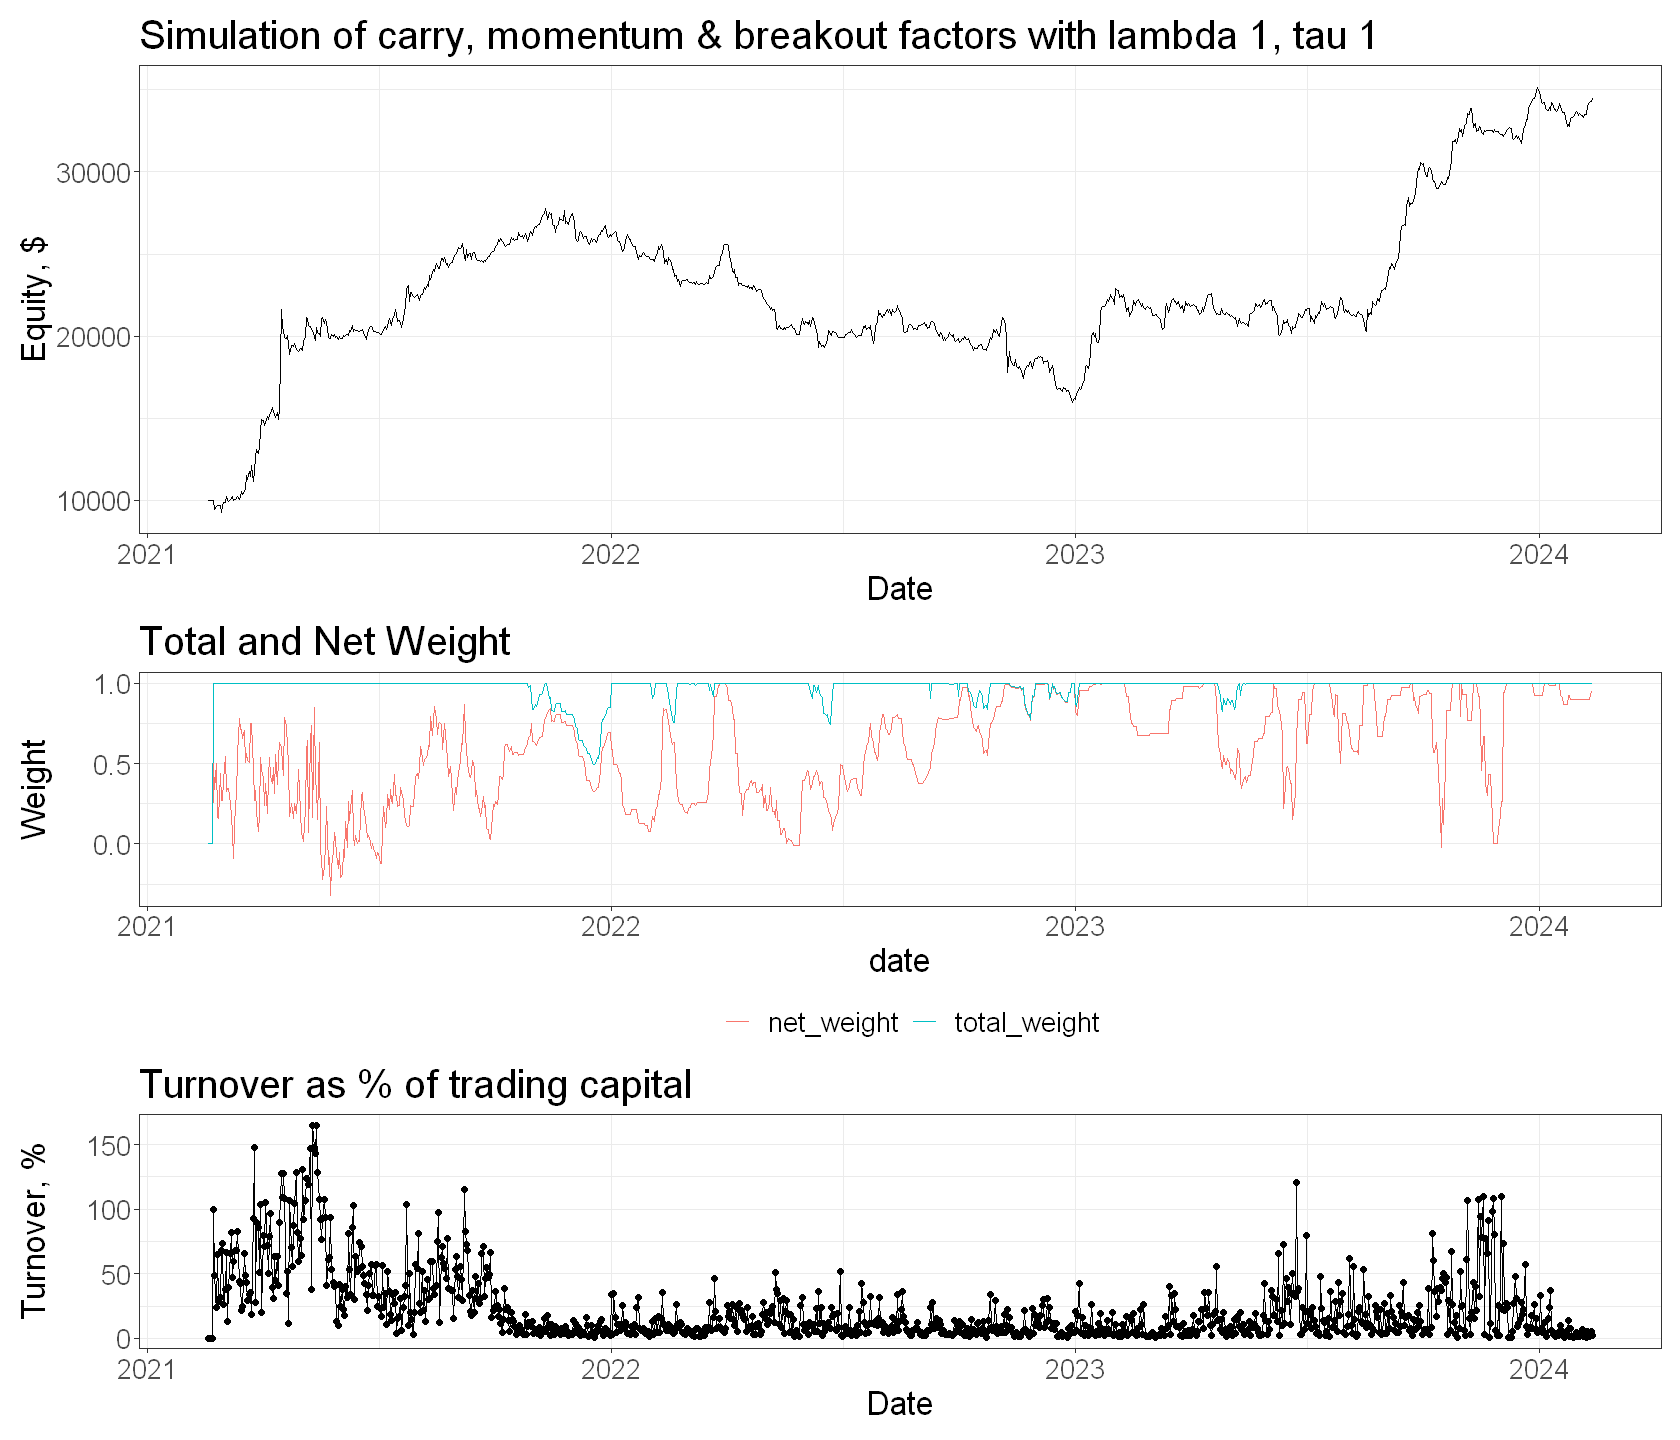

In [63]:
# plot results
equity_plot <- equity %>% 
  ggplot(aes(x = Date, y = Equity)) + 
  geom_line() +
  labs(
    title = "Simulation of carry, momentum & breakout factors with lambda 1, tau 1",
    y = "Equity, $"
  )

weights_plot <- backtest_df %>%
  group_by(date) %>% 
  summarise(
    total_weight = sum(abs(weight)),
    net_weight = sum(weight)
  ) %>% 
  pivot_longer(-date, names_to = "type", values_to = "weight") %>% 
  ggplot(aes(x = date, y = weight, colour = type)) +
  geom_line() +
  labs(
    title = "Total and Net Weight",
    y = "Weight",
    colour = ""
  ) +
  theme(legend.position = "bottom")

turnover_plot <- results_df  %>% 
  filter(ticker != "Cash") %>% 
  group_by(Date) %>% 
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>% 
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

options(repr.plot.width = 14, repr.plot.height=12)
equity_plot / weights_plot / turnover_plot + plot_layout(heights = c(2, 1, 1))
options(repr.plot.width = 14, repr.plot.height=7)

Notice that we get quite long from time to time. And sometimes we're not quite fully invested. Maybe that's what you want, maybe not. 

Let's repeat the process, but this time constrain the portfolio to a maximum net weight of +/- 0.5:

In [65]:
# define our mvo function
mvo_with_costs_constrained <- function(expected_returns, current_weights, na_idxs = c(), costs, covmat, lambda = 1, tau = 1) {
  # define our weights vector as a CVXR::Variable
  weights <- Variable(length(expected_returns))
  # define an alpha term as the weighted sum of expected returns
    # again, express using linear algebra
  alpha_term <- (t(weights) %*% expected_returns)
  # define a costs term. depends on:
    # cost of trading - needs to be expressed such that it scales with expected returns
      # calculate as elementwise cost * absolute value of weights - current_weights
      # use CVXR::multiply and CVXR::abs
    # absolute distance of current_weights to our weights variable
      # the more our target weights differ from current weights, the more it costs to trade
      # this is a decent representation of fixed percentage costs, but doesn't capture minimum commissions
    # sum_entries is a CVXR function for summing the elements of a vector
  costs_term <- sum_entries(multiply(costs, abs(weights - current_weights))) # elementwise abs, multiply
  # define a risk term as w*Sigma*w
    # quad_form is a CVXR function for doing w*Sigma*w
  risk_term <- quad_form(weights, covmat)
  # define our objective
    # maximise our alpha less our risk term multiplied by some factor, lambda, less our costs term multiplied by tau
  objective <- Maximize(alpha_term - lambda*risk_term - tau*costs_term)
  # constrain to a maximum net weight +/- 0.5, maximum leverage 1
  constraints <- list(cvxr_norm(weights, 1) <= 1, abs(sum_entries(weights)) <= 0.5, weights[na_idxs] == 0)
  # specify the problem
  problem <- Problem(objective, constraints)
  # solve
  result <- solve(problem)

  # return the values of the variable we solved for
  result$getValue(weights)
}

In [66]:
lambda <- 1
tau <- 1
weights <- list()
errors <- list()
w0 <- rep(0, length(universe_tickers))
for( i in c(1:length(exp_returns_sim_df$date)) ) {
    # today's date
    d = exp_returns_sim_df$date[i]

    # cov estimate
    today_covmat <- covmat_list[[i]]

    # check cov matrix and exp returns vector are ticker-aligned
    # all.equal(exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(ticker), colnames(today_covmat))
    
    # get row of expected returns as a vector in the same order as the columns of the covariance matrix
    # contains NA at this point
    exp_rets <- exp_returns_sim_df %>% filter(date == d) %>% pivot_longer(-date, names_to = "ticker", values_to = "expected_return")%>% arrange(match(ticker, universe_tickers)) %>% pull(expected_return)
    # get na indexes
    # we'll explicitly constrain these to get zero weight
    na_idxs <- which(is.na(exp_rets))
    # convert NA to zero
    exp_rets[is.na(exp_rets)] <- 0
    # initialise w in case we get a solver error (can retain w0 in these cases)
    w <- w0
    tryCatch({
        w <- mvo_with_costs_constrained(expected_returns = exp_rets, current_weights = w0, na_idxs = na_idxs, costs = costs, covmat = today_covmat, lambda = lambda, tau = tau)
    }, error = function(e) {
        # in case of solver error, log and retain existing weights
        errors[[i]] <- e
        }
    )
    
    # w is a one-column matrix
    weights[[i]] <- w
    w0 <- w 
}

saveRDS(results, file = "lambda_1_tau_1_net_weight_constrained.rds")

In [67]:
# wrangle weights into a dataframe
weights_df <- purrr::map2(
  weights, 
  exp_returns_sim_df$date, 
  ~weights_mat_to_df(.x, .y, lambda = lambda, tau = tau, tickers = universe_tickers)
) %>% 
  bind_rows() %>% 
  rename("weight" = lambda_1_tau_1)

# join weights onto prices
backtest_df <- weights_df %>% 
  left_join(strategy_df, by = c("ticker", "date"))

head(backtest_df)

weight,date,ticker,expected_return,close,total_fwd_return_simple,funding_rate
<dbl>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,2021-02-18,BTCUSDT,NA,51663.6400,0.041106415,-0.00412394
0,2021-02-18,ETHUSDT,NA,1910.9900,0.007813203,-0.00516012
0,2021-02-18,BCHUSDT,NA,702.5500,0.015704896,-0.00711178
0,2021-02-18,XRPUSDT,NA,0.5302,0.030592698,-0.00688510
0,2021-02-18,EOSUSDT,NA,4.8000,0.077784750,-0.00550166
0,2021-02-18,LTCUSDT,NA,225.8000,0.020896880,-0.00616800


In [68]:
# simulate

# get weights as a wide matrix 
backtest_weights <- backtest_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("weight")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

# get prices as a wide matrix
backtest_prices <- backtest_df %>% 
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("close_")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# get funding as a wide matrix
backtest_funding <- backtest_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(date, starts_with("funding_rate_")) %>%
  mutate(date = as.numeric(date)) %>% 
  data.matrix()

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = 0.,
  initial_cash = 10000,
  margin = 0.05,
  commission_pct = 0.0015,
  capitalise_profits = FALSE
) %>%
mutate(ticker = str_remove(ticker, "close_")) %>%
# remove coins we don't trade from results
drop_na(Value)

margin <- results_df %>%
  group_by(Date) %>%
  summarise(Margin = sum(Margin, na.rm = TRUE))

cash_balance <- results_df %>%
  filter(ticker == "Cash") %>%
  select(Date, Value) %>%
  rename("Cash" = Value)

equity <- cash_balance %>%
  left_join(margin, by = "Date") %>% 
  mutate(Equity = Cash + Margin) %>% 
  select(Date, Equity) 

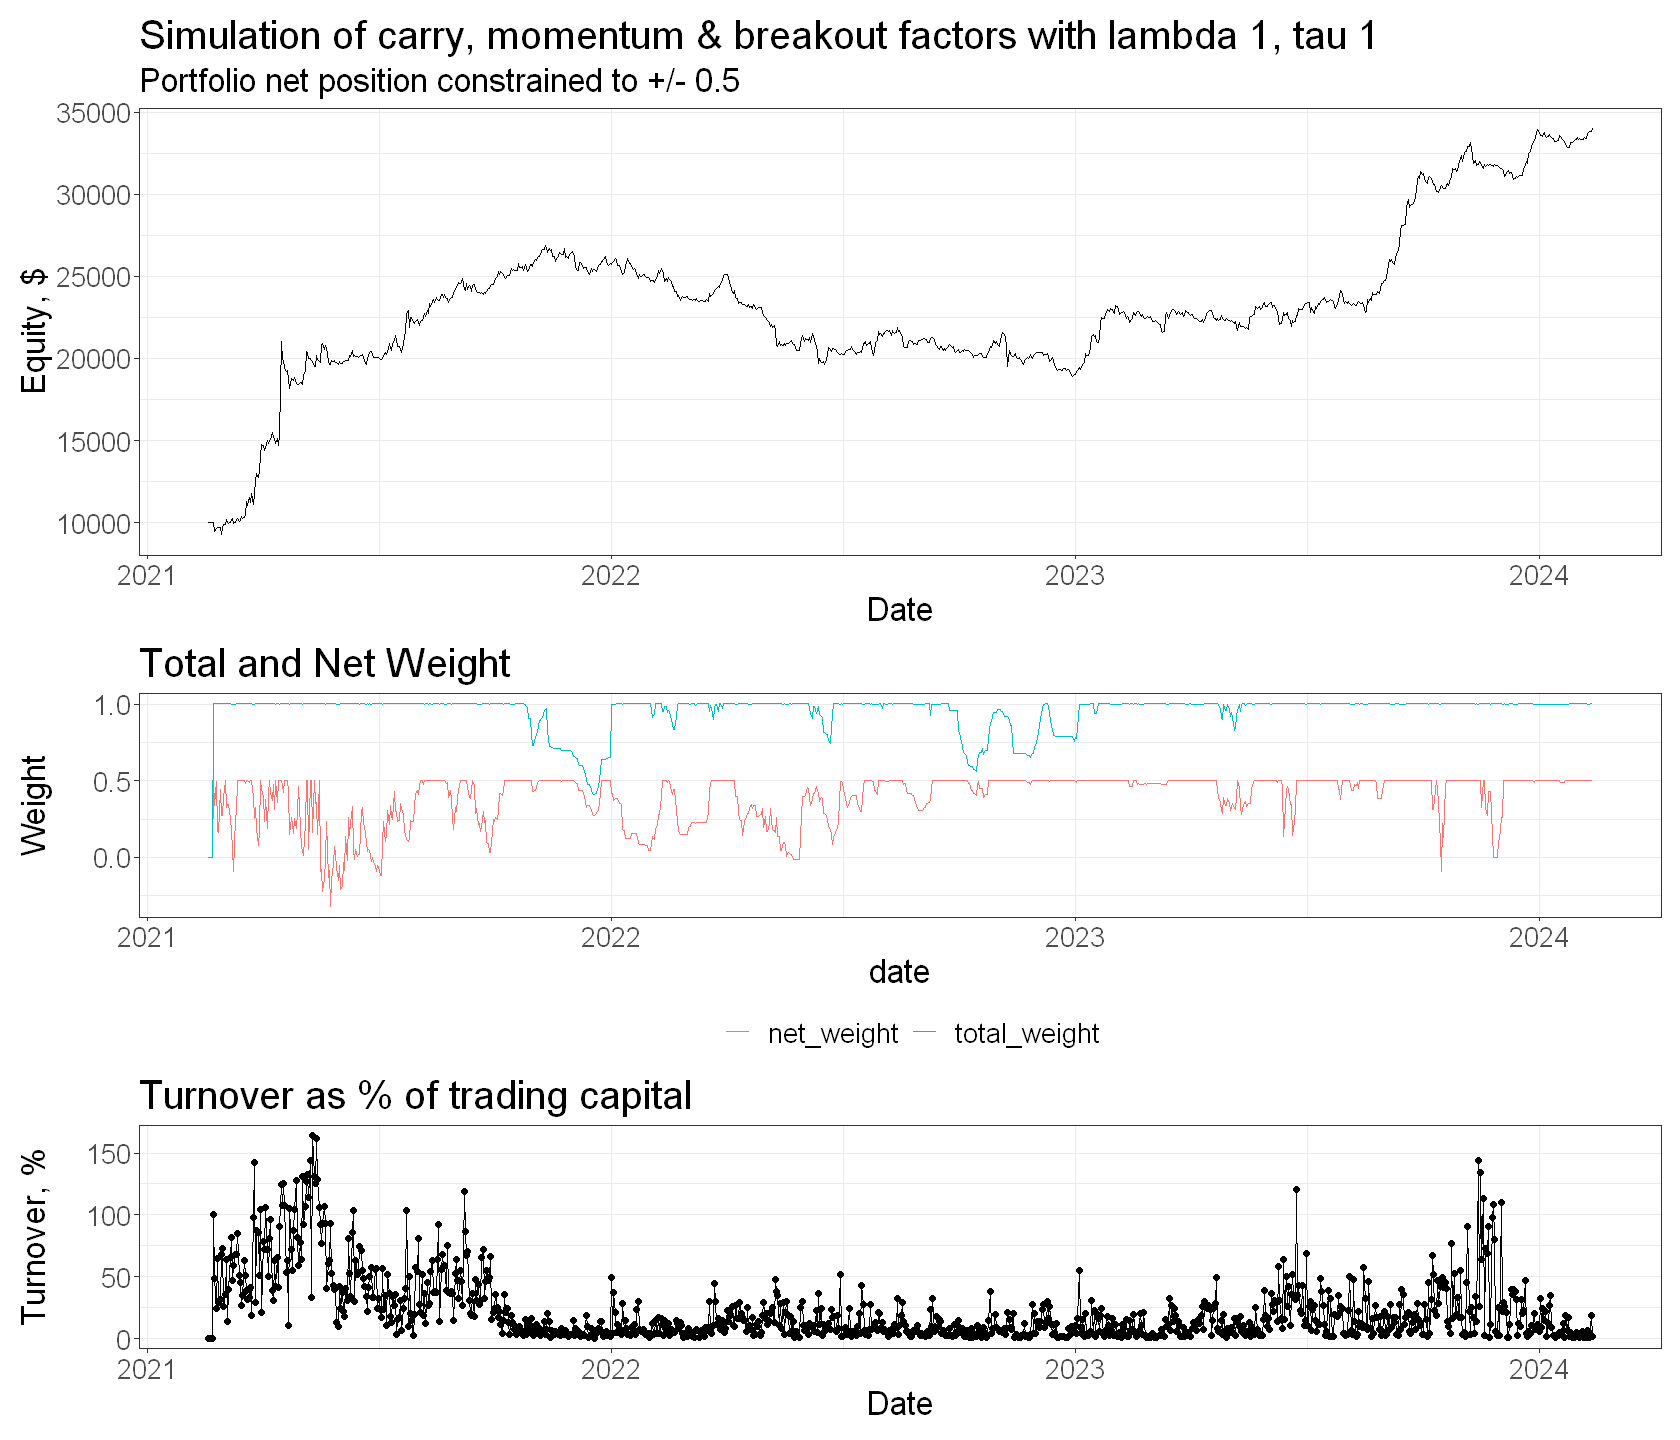

In [70]:
# plot results
equity_plot <- equity %>% 
  ggplot(aes(x = Date, y = Equity)) + 
  geom_line() +
  labs(
    title = "Simulation of carry, momentum & breakout factors with lambda 1, tau 1",
    subtitle = "Portfolio net position constrained to +/- 0.5",
    y = "Equity, $"
  )

weights_plot <- backtest_df %>%
  group_by(date) %>% 
  summarise(
    total_weight = sum(abs(weight)),
    net_weight = sum(weight)
  ) %>% 
  pivot_longer(-date, names_to = "type", values_to = "weight") %>% 
  ggplot(aes(x = date, y = weight, colour = type)) +
  geom_line() +
  labs(
    title = "Total and Net Weight",
    y = "Weight",
    colour = ""
  ) +
  theme(legend.position = "bottom")

turnover_plot <- results_df  %>% 
  filter(ticker != "Cash") %>% 
  group_by(Date) %>% 
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>% 
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

options(repr.plot.width = 14, repr.plot.height=12)
equity_plot / weights_plot / turnover_plot + plot_layout(heights = c(2, 1, 1))
options(repr.plot.width = 14, repr.plot.height=7)

You can see that now the portfolio never gets more than 50% net long. You can adjust this constraint further, and add any of your own, if you like. 

## Conclusions

In this article, we demonstrated how to frame the trading problem - that is, how to navigate the tradeoffs between edge, costs, and constraints - as a mathematical optimisation problem, and how to simulate trading the output of the optimisation. 

We showed how you can control the optimiser's decisions with the lambda (risk aversion) and tau (propensity to trade) parameters. We saw how different parameter values affect the optimiser's trading decisions. 

It's worth reiterating that optimisation doesn't represent alpha. Your alpha is embedded in your forecasts of expected returns. Optimisation is a tool for navigating the tradeoffs involved with harnessing your expected returns, but it doesn't provide any alpha itself. This implies that the real work is in finding, quantifying and understanding your signals. 

If using a risk model in your optimisation, like we did here with our covariance matrixes, it's important to note that the optimiser can be very sensitive to your covariance estimates. It's reasonable to shrink these estimates as a reflection of the inherent uncertainty. 

How does the optimisation approach stack up against the heuristic no-trade buffer that we explored [earlier](https://robotwealth.com/a-simple-effective-way-to-manage-turnover-and-not-get-killed-by-costs/)? The heuristic is simpler to reason about and implement. But it requires a bit more fudging upstream, particularly if you wanted to incorporate a risk model. 

The optimisation approach is fiddly to set up at the outset, but extremely scalable once set up. It requires some skill in modelling expected returns and covariances. 